In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandana
import contextily as cx

%matplotlib inline

In [3]:
# Seleccionamos áreas de estudio y proyección CRS
vitacura = 'Vitacura, Provincia de Santiago, Región Metropolitana de Santiago, Chile'
las_condes = 'Las Condes, Provincia de Santiago, Región Metropolitana de Santiago, Chile'
provi = 'Providencia, Provincia de Santiago, Región Metropolitana de Santiago, Chile'
crs = 3042

In [5]:
area_vitacura = ox.geocode_to_gdf(vitacura)
area_lascondes = ox.geocode_to_gdf(las_condes)
area_provi = ox.geocode_to_gdf(provi)

### Area de Estudio: Vitacura, Las Condes y Providencia

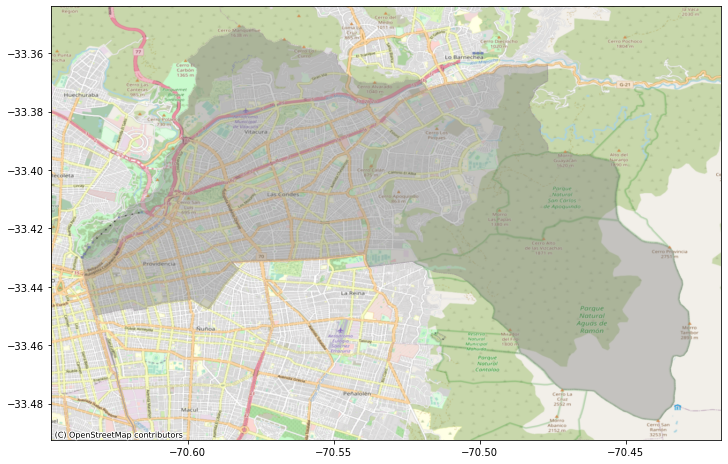

In [5]:
f, ax = plt.subplots(1, figsize=(12, 12))
area_vitacura.plot(ax=ax, alpha=0.4, color='grey')
area_lascondes.plot(ax=ax, alpha=0.4, color='grey')
area_provi.plot(ax=ax, alpha=0.4, color='grey')
cx.add_basemap(ax, crs=area_vitacura.crs, source=cx.providers.OpenStreetMap.Mapnik);
#plt.savefig('../15MinuteCity/images/madrid/areaestudio_madrid.jpg', dpi=400, bbox_inches='tight')

In [6]:
res_union = area_vitacura.overlay(area_lascondes, how='union')

C:\Users\Pablo\miniconda3\lib\site-packages\geopandas\geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [7]:
union = res_union.overlay(area_provi, how='union')

C:\Users\Pablo\miniconda3\lib\site-packages\geopandas\geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [9]:
comunas = union.dissolve()
comunas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

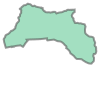

In [10]:
comunas.iloc[0]['geometry']

In [25]:
graph = ox.graph_from_polygon(polygon = comunas.iloc[0]['geometry'], network_type="walk")

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
nodes, edges = ox.graph_to_gdfs(graph)

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


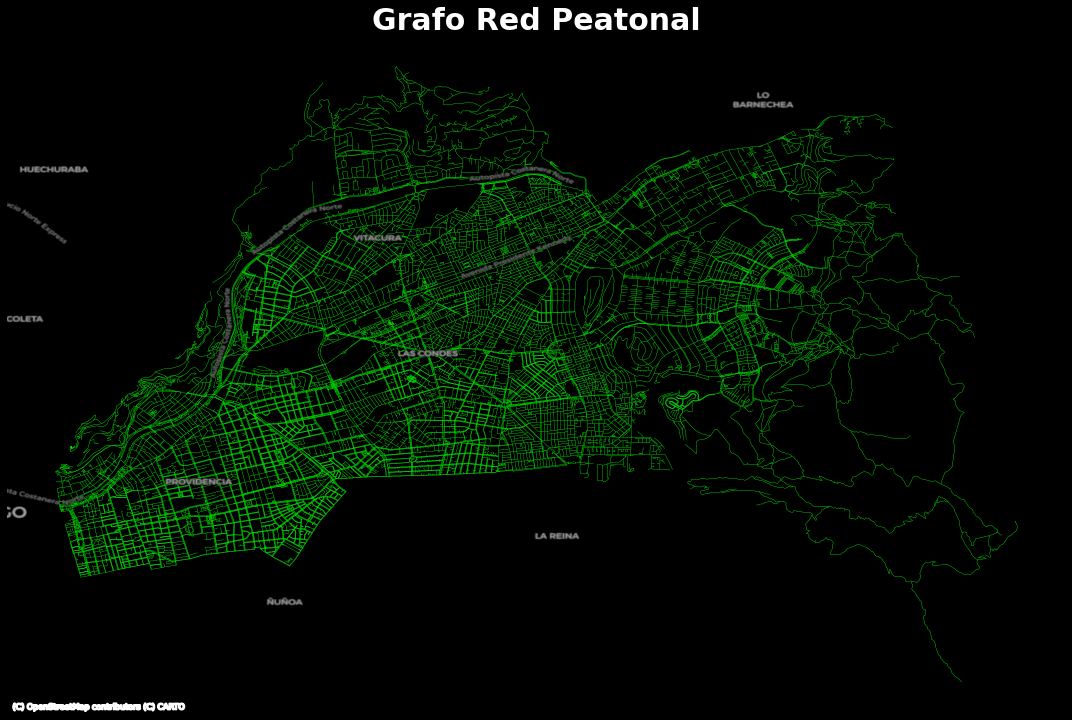

In [58]:
fig, ax = plt.subplots(figsize=(15,12))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')
ax.set_title('Grafo Red Peatonal', fontsize=30, fontweight='bold')

edges.plot(
    ax=ax,
    color='lime',
    linewidth=0.2
)
cx.add_basemap(ax, crs=edges.crs, source=cx.providers.CartoDB.DarkMatterOnlyLabels);
#plt.savefig('../Chile/15mins/grafo_tres_comunas.jpg', dpi=400, bbox_inches='tight')
plt.tight_layout()

In [46]:
print(
    'number of nodes:\n\noriginal graph: '+str(len(nodes))
    +'\nsimplified graph: '+str(len(edges))
)

number of nodes:

original graph: 24316
simplified graph: 73766


C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# Tags1: Colegios y Parques
tags1 = {'amenity':['school']}

In [48]:
# Tags2: Jardin Infantil (kindergarten)
tags2 = {'amenity':['kindergarten']}

### Analisis Tags

In [49]:
pois = ox.geometries.geometries_from_polygon(polygon = comunas.iloc[0]['geometry'], tags=tags2)

In [50]:
# Tiempo máximo caminando en minutos
walk_time = 15

# Velocidad caminando
walk_speed = 10

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# Extraemos nodos y aristas
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# Construimos red de Pandana
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extraemos los centroides de los POIs
centroids = pois.centroid

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-557e8a54946f>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pois.centroid


In [52]:
maxdist = walk_time * 60

# Establecemos los POIs en la network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Pablo\miniconda3\lib\site-packages\pandana\network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
C:\Users\Pablo\miniconda3\lib\site-packages\pandana\network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [53]:
# Calculamos tiempo de desplazamiento para los 10 POIs más cercanos desde cada nodo de la red
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
388703,111,224,227,240,247,317,345,362,376,406
388705,165,186,300,353,381,391,407,409,522,534
13876993,80,146,155,221,250,278,296,302,335,391
13876995,169,173,228,278,282,323,364,365,390,395
13876998,166,205,228,246,266,268,277,277,281,303


#### Grafo 15 minutos

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


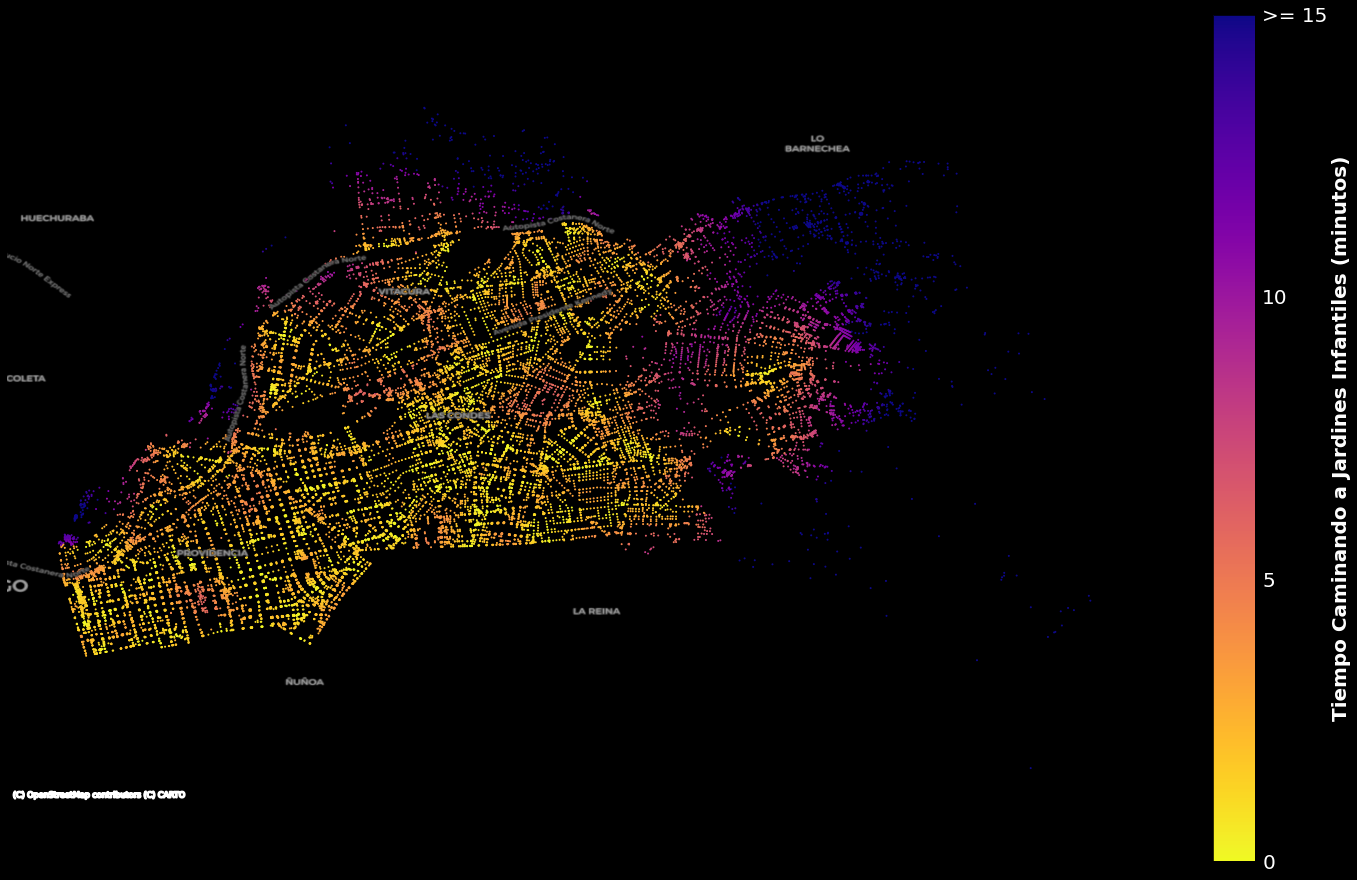

In [54]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))


sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='plasma_r',
)
cx.add_basemap(ax, crs=pois.crs, source=cx.providers.CartoDB.DarkMatterOnlyLabels);

# Colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Tiempo Caminando a Jardines Infantiles (minutos)', fontsize=20, fontweight='bold')

plt.tight_layout()

#plt.savefig('../Chile/15mins/kinder_trescomunas.jpg', dpi=400, bbox_inches='tight')

In [93]:
tags_school = {
    'amenity':[
        'kindergarten',
        'school'        
    ]}

tags_park = {
    'leisure':[
        'parks',
        'playground']
}

In [94]:
pois_school = ox.geometries.geometries_from_polygon(polygon = comunas.iloc[0]['geometry'], tags=tags_school)
pois_park = ox.geometries.geometries_from_polygon(polygon = comunas.iloc[0]['geometry'], tags=tags_park)

In [19]:
# Project pois
pois_school = pois_school.to_crs(epsg=crs)
pois_park = pois_park.to_crs(epsg=crs)

In [95]:
centroids_school = pois_school.centroid
centroids_park = pois_park.centroid

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-95-0fc876640e92>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_school = pois_school.centroid
<ipython-input-95-0fc876640e92>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_park = pois_park.centroid


#### Grafo POIs Colegios y Parques

C:\Users\Pablo\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


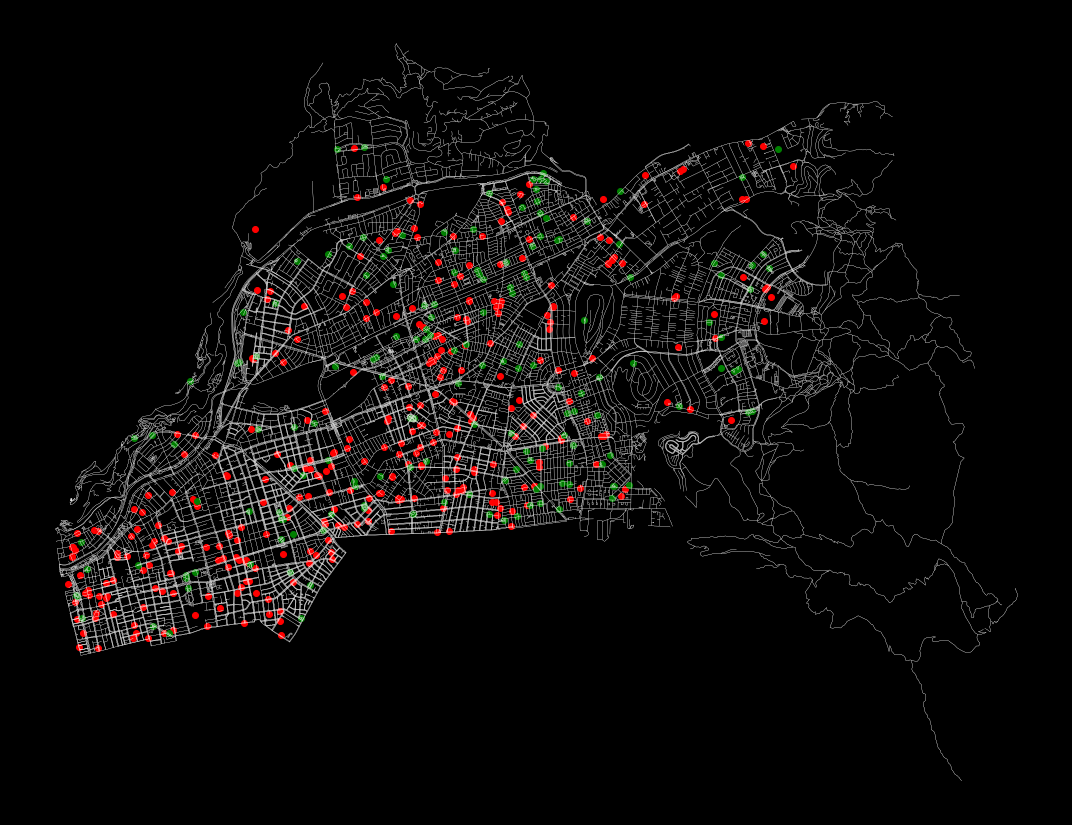

In [115]:
fig, ax = plt.subplots(figsize=(15,12))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')
#ax.set_title('Grafo Red Peatonal de Madrid', fontsize=30, fontweight='bold')

edges.plot(
    ax=ax,
    color='white',
    linewidth=0.2
)
centroids_school.plot(ax=ax, c='red')
centroids_park.plot(ax=ax, c='green')

plt.tight_layout()
#plt.savefig('../Chile/15mins/pois_colegiosparques.jpg', dpi=400, bbox_inches='tight')